# Notebook 06 — Course Recommender & Learning Path Generator
## Kenya Career & Skills Intelligence System

This notebook builds the **Course Recommendation & Learning Path** component — the system's final user-facing output that tells users *exactly what to learn and where to learn it*.

### What this notebook does

| Component | Description |
|---|---|
| Gap-Driven Course Selection | Recommends courses that directly address identified skill gaps (from Notebook 04) |
| Multi-Platform Matching | Searches Coursera, edX, Udemy across free and paid tiers |
| Skill Match % per Course | Scores each course against the user's gap profile |
| Learning Path Sequencer | Structures courses into Foundation → Intermediate → Advanced stages |
| Kenya-Localised Options | Surfaces Africa-relevant institutions and MOOCs |
| Priority & Duration Estimator | Estimates total learning time per path |

### Inputs
- `unified_courses.parquet` — course catalogue from Notebook 02
- `career_risk_profiles.parquet` — risk profiles from Notebook 05
- `skills_gap_engine.pkl` — gap engine from Notebook 04

### Outputs
- `course_recommender.pkl` — serialised TF-IDF course recommender
- `06_course_recommender_summary.json` — summary

## 1.0 — Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
import joblib
import json
import re
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

warnings.filterwarnings('ignore')

PROCESSED_DIR  = Path('DATA/processed')
MODEL_DIR      = Path('models')
ARTIFACTS_DIR  = Path('artifacts')
FIGURES_DIR    = Path('figures')

for d in [PROCESSED_DIR, MODEL_DIR, ARTIFACTS_DIR, FIGURES_DIR]:
    d.mkdir(parents=True, exist_ok=True)



## 2.0 — Load Course Catalogue and Supporting Data

In [2]:
# ── Load unified course catalogue (built in Notebook 02) ─────────────────────
courses = pd.read_parquet(PROCESSED_DIR / 'unified_courses.parquet')
print(f'Unified course catalogue  : {courses.shape}')
print(f'Columns                   : {courses.columns.tolist()}')
print()
print('Platform distribution:')
display(courses['platform'].value_counts())

# ── Load risk profiles (from Notebook 05) ────────────────────────────────────
risk_profiles = pd.read_parquet(PROCESSED_DIR / 'career_risk_profiles.parquet')
print(f'\nRisk profiles loaded      : {len(risk_profiles)}')

Unified course catalogue  : (8050, 14)
Columns                   : ['course_title', 'platform', 'institution', 'subject', 'level', 'skills_covered', 'effort', 'price', 'url', 'rating', 'num_reviews', 'rating_norm', 'popularity_norm', 'quality_score']

Platform distribution:


platform
Udemy       3672
Coursera    3404
edX          974
Name: count, dtype: int64


Risk profiles loaded      : 894


In [3]:
# ── Inspect course schema ─────────────────────────────────────────────────────
print('=== Course catalogue sample ===')
display(courses.sample(5, random_state=42))

# Check key fields
key_fields = ['course_title', 'subject', 'skills_covered', 'platform', 'level',
              'quality_score', 'url', 'duration_hours', 'is_free']
print('\nField availability:')
for f in key_fields:
    if f in courses.columns:
        n_valid = courses[f].notna().sum()
        print(f'  {f:25s} : {n_valid:5d}/{len(courses)} ({n_valid/len(courses)*100:.0f}%)')
    else:
        print(f'  {f:25s} : NOT PRESENT')

=== Course catalogue sample ===


,course_title,platform,institution,subject,level,skills_covered,effort,price,url,rating,num_reviews,rating_norm,popularity_norm,quality_score
743,Probability and Statistics I: A Gentle Introd...,edX,The Georgia Institute of Technology,Data Analysis & Statistics,Intermediate,"“FCPS” refers to the free text, A First Course...",6–10 hours per week,FREE-Add a Verified Certificate for $199 USD,https://www.edx.org/course/probability-and-sta...,NaN,NaN,0.70,0.300000,0.540000
1501,"Day trading strategy for all level, with 72% s...",Udemy,Udemy,Business Finance,All Levels,Business Finance,0.5333333333333333 hrs,95,https://www.udemy.com/1-shot-1kill/,NaN,9.0,0.70,0.183740,0.493496
5368,Qualitative Research,Coursera,"University of California, Davis",Business,Intermediate,"Corporate Finance, Financial Management, Busin...",1 - 4 Weeks,Free audit,,4.7,147.0,0.94,0.398763,0.723505
4708,Financing and Investing in Infrastructure,Coursera,Università Bocconi,Business,Mixed,"Project Finance, Risk Analysis, Capital Budget...",1 - 3 Months,Free audit,,4.8,2000.0,0.96,0.606570,0.818628
6414,Basic Cryptography and Programming with Crypto...,Coursera,University of Colorado System,Computer Science,Intermediate,"Cryptography, Data Encryption Standard, Encryp...",1 - 4 Weeks,Free audit,,4.2,29.0,0.84,0.271406,0.612562



Field availability:
  course_title              :  8050/8050 (100%)
  subject                   :  8050/8050 (100%)
  skills_covered            :  8050/8050 (100%)
  platform                  :  8050/8050 (100%)
  level                     :  8050/8050 (100%)
  quality_score             :  8050/8050 (100%)
  url                       :  8050/8050 (100%)
  duration_hours            : NOT PRESENT
  is_free                   : NOT PRESENT


## 3.0 — Course Level Classifier

Ensures every course has a reliable Foundation / Intermediate / Advanced label.

In [4]:
# ── Standardise level labels ──────────────────────────────────────────────────
LEVEL_MAP = {
    'beginner'      : 'Foundation',
    'introductory'  : 'Foundation',
    'intro'         : 'Foundation',
    'basic'         : 'Foundation',
    'all levels'    : 'Foundation',
    'foundation'    : 'Foundation',
    'intermediate'  : 'Intermediate',
    'mixed'         : 'Intermediate',
    'advanced'      : 'Advanced',
    'expert'        : 'Advanced',
    'professional'  : 'Advanced',
}

def standardise_level(raw: str) -> str:
    if pd.isna(raw):
        return 'Foundation'
    cleaned = raw.lower().strip()
    for key, label in LEVEL_MAP.items():
        if key in cleaned:
            return label
    return 'Intermediate'   # default


courses['std_level'] = courses['level'].apply(standardise_level) if 'level' in courses.columns \
                       else 'Foundation'

print('Standardised course levels:')
display(courses['std_level'].value_counts().reset_index())

Standardised course levels:


,std_level,count
0,Foundation,5555
1,Intermediate,2205
2,Advanced,290


## 4.0 — Build Enhanced Course TF-IDF Index

Extended from Notebook 03's basic title-level index to include subject, skills covered, and level signals.

In [5]:
# ── Build rich course text for TF-IDF ─────────────────────────────────────────
def build_course_text(row: pd.Series) -> str:
    """Concatenate all text signals for a course into a searchable string."""
    parts = [
        str(row.get('course_title', ''))   * 3,   # title triple-weighted
        str(row.get('skills_covered', '')),
        str(row.get('subject', '')),
        str(row.get('std_level', '')),
        str(row.get('platform', '')),
    ]
    return ' '.join(filter(None, parts)).lower().strip()


courses['course_text'] = courses.apply(build_course_text, axis=1)

# ── Fit TF-IDF vectoriser ─────────────────────────────────────────────────────
COURSE_TFIDF = TfidfVectorizer(
    ngram_range      = (1, 3),
    max_features     = 15000,
    strip_accents    = 'unicode',
    min_df           = 1,
    sublinear_tf     = True,
)

COURSE_MATRIX = COURSE_TFIDF.fit_transform(courses['course_text'])
print(f'Course TF-IDF matrix : {COURSE_MATRIX.shape}')
print(f'Vocabulary size      : {len(COURSE_TFIDF.vocabulary_):,}')

joblib.dump(COURSE_TFIDF,  MODEL_DIR / 'course_tfidf_v2.pkl')
joblib.dump(COURSE_MATRIX, MODEL_DIR / 'course_matrix_v2.pkl')
print('Course TF-IDF index saved')

Course TF-IDF matrix : (8050, 15000)
Vocabulary size      : 15,000
Course TF-IDF index saved


## 5.0 — Gap-Driven Course Search

The key upgrade over the basic career-title search in Notebook 03.
This version searches per-gap, ensuring courses directly address the user's skill deficits.

In [6]:
def search_courses_for_skill(
    skill_name  : str,
    top_k       : int = 3,
    level_filter: str | None = None,
    min_quality : float = 0.3,
) -> pd.DataFrame:
    """
    Find top courses that address a specific skill gap.

    Parameters
    ----------
    skill_name   : str  O*NET skill dimension name (e.g., 'programming', 'critical thinking')
    top_k        : int  max courses to return
    level_filter : str  'Foundation' | 'Intermediate' | 'Advanced' | None (no filter)
    min_quality  : float  minimum quality score filter

    Returns
    -------
    pd.DataFrame of matching courses
    """
    query     = skill_name.lower().replace('_', ' ')
    query_vec = COURSE_TFIDF.transform([query])
    sims      = cosine_similarity(query_vec, COURSE_MATRIX)[0]

    # Apply level filter to candidates pool
    candidate_mask = courses['quality_score'].fillna(0) >= min_quality if 'quality_score' in courses.columns \
                     else np.ones(len(courses), dtype=bool)

    if level_filter:
        level_mask     = courses['std_level'] == level_filter
        candidate_mask = candidate_mask & level_mask

    masked_sims = sims * candidate_mask.astype(float)
    top_idx     = np.argsort(masked_sims)[::-1][:top_k * 3]   # retrieve more, then trim
    top_idx     = [i for i in top_idx if masked_sims[i] > 0.01][:top_k]

    results = []
    for idx in top_idx:
        row = courses.iloc[idx]
        results.append({
            'Course Title'   : row.get('course_title', 'Unknown'),
            'Platform'       : row.get('platform', 'Unknown'),
            'Level'          : row.get('std_level', 'Unknown'),
            'Subject'        : row.get('subject', ''),
            'Skills Covered' : str(row.get('skills_covered', ''))[:80],
            'Quality Score'  : round(float(row.get('quality_score', 0)), 2),
            'Duration (hrs)' : row.get('duration_hours', 'N/A'),
            'Is Free'        : row.get('is_free', False),
            'URL'            : row.get('url', ''),
            'Skill Match %'  : round(float(masked_sims[idx]) * 100, 1),
            'Skill Gap'      : skill_name.replace('_', ' ').title(),
        })

    return pd.DataFrame(results)


# ── Quick test ────────────────────────────────────────────────────────────────
# for the filter the first character should be capitalised to match the standardised levels in the catalogue
test_courses = search_courses_for_skill('programming', top_k=3, level_filter='Advanced')
print('=== Test: Advanced courses for Programming ===')
if not test_courses.empty:
    display(test_courses[['Course Title', 'Platform', 'Level', 'Skill Match %', 'Duration (hrs)']].head())
else:
    print('No courses matched — check course catalogue.')

=== Test: Advanced courses for Programming ===


,Course Title,Platform,Level,Skill Match %,Duration (hrs)
0,Genome Assembly Programming Challenge,Coursera,Advanced,20.6,N/A
1,Approximation Algorithms and Linear Programming,Coursera,Advanced,17.4,N/A
2,"Dynamic Programming, Greedy Algorithms",Coursera,Advanced,16.7,N/A


## 6.0 — Learning Path Sequencer

Takes gap analysis output and builds a structured, staged learning path:
1. **Foundation** — address critical gaps with beginner courses
2. **Intermediate** — address moderate gaps
3. **Advanced** — specialisation and certification

In [7]:
# ── Education-level appropriate course level mapping ─────────────────────────
EDUCATION_COURSE_LEVELS = {
    'cbc'          : ['Foundation'],
    '8-4-4'        : ['Foundation', 'Intermediate'],
    'diploma'      : ['Foundation', 'Intermediate'],
    'graduate'     : ['Intermediate', 'Advanced'],
    'postgraduate' : ['Advanced'],
    'professional' : ['Intermediate', 'Advanced'],
}


def generate_learning_path(
    gap_report    : dict,
    user_type     : str = 'graduate',
    courses_per_gap: int = 2,
    max_stages    : int = 3,
) -> dict:
    """
    Build a structured, staged learning path from a gap report.

    Parameters
    ----------
    gap_report      : dict  output from analyse_skills_gap() in Notebook 04
    user_type       : str   user education level
    courses_per_gap : int   max courses per skill gap
    max_stages      : int   max stages to build

    Returns
    -------
    dict with staged learning path and summary metrics
    """
    preferred_levels = EDUCATION_COURSE_LEVELS.get(user_type.lower(), ['Foundation', 'Intermediate'])
    all_gaps         = gap_report.get('all_gaps', [])

    if not all_gaps:
        return {'stages': [], 'summary': 'No skill gaps identified — you are well aligned.'}

    # ── Stage 1: Foundation — Critical Gaps ───────────────────────────────────
    critical_gaps  = [g for g in all_gaps if g['Severity'] == 'Critical']
    moderate_gaps  = [g for g in all_gaps if g['Severity'] == 'Moderate']

    stages = []

    # Foundation: beginner level courses for critical gaps
    stage1_courses = []
    for gap in critical_gaps[:4]:
        skill_key = gap['Skill'].lower().replace(' ', '_')
        level     = preferred_levels[0] if preferred_levels else 'Foundation'
        found     = search_courses_for_skill(skill_key, top_k=courses_per_gap, level_filter=level)
        if found.empty:
            found = search_courses_for_skill(skill_key, top_k=courses_per_gap, level_filter=None)
        if not found.empty:
            found['Gap Priority'] = gap['Priority Order']
            stage1_courses.append(found)

    if stage1_courses:
        stage1_df = pd.concat(stage1_courses, ignore_index=True)
        stages.append({
            'stage'       : 1,
            'label'       : 'Stage 1 — Foundation: Close Critical Gaps',
            'description' : 'Master the core skills you are most lacking for this career.',
            'courses'     : stage1_df,
            'skill_focus' : [g['Skill'] for g in critical_gaps[:4]],
            'est_hours'   : _estimate_hours(stage1_df),
        })

    # Intermediate: moderate gaps
    if len(stages) < max_stages and moderate_gaps:
        stage2_courses = []
        for gap in moderate_gaps[:4]:
            skill_key = gap['Skill'].lower().replace(' ', '_')
            level     = preferred_levels[1] if len(preferred_levels) > 1 else 'Intermediate'
            found     = search_courses_for_skill(skill_key, top_k=courses_per_gap, level_filter=level)
            if found.empty:
                found = search_courses_for_skill(skill_key, top_k=courses_per_gap, level_filter=None)
            if not found.empty:
                stage2_courses.append(found)

        if stage2_courses:
            stage2_df = pd.concat(stage2_courses, ignore_index=True)
            stages.append({
                'stage'       : 2,
                'label'       : 'Stage 2 — Intermediate: Build Core Competencies',
                'description' : 'Develop the skills you need to be competitive in this career.',
                'courses'     : stage2_df,
                'skill_focus' : [g['Skill'] for g in moderate_gaps[:4]],
                'est_hours'   : _estimate_hours(stage2_df),
            })

    # Advanced: career-title level courses for specialisation
    if len(stages) < max_stages:
        career_title = gap_report.get('occupation', '')
        adv_courses  = search_courses_for_skill(
            career_title.lower(), top_k=3, level_filter='Advanced'
        )
        if adv_courses.empty:
            adv_courses = search_courses_for_skill(career_title.lower(), top_k=3)
        if not adv_courses.empty:
            stages.append({
                'stage'       : 3,
                'label'       : 'Stage 3 — Advanced: Specialisation & Certification',
                'description' : f'Complete professional-level courses and certifications for {career_title}.',
                'courses'     : adv_courses,
                'skill_focus' : [career_title],
                'est_hours'   : _estimate_hours(adv_courses),
            })

    # Summary metrics
    total_hours   = sum(s['est_hours'] for s in stages)
    total_courses = sum(len(s['courses']) for s in stages)

    return {
        'occupation'   : gap_report.get('occupation', 'Unknown'),
        'alignment_pct': gap_report.get('alignment_pct', 0),
        'stages'       : stages,
        'total_courses': total_courses,
        'est_total_hours': round(total_hours, 1),
        'summary'      : (
            f"{total_courses} courses across {len(stages)} stages, "
            f"estimated {total_hours:.0f} learning hours."
        ),
    }


def _estimate_hours(courses_df: pd.DataFrame) -> float:
    """Estimate total learning hours from a set of courses."""
    if 'Duration (hrs)' in courses_df.columns:
        hrs = pd.to_numeric(courses_df['Duration (hrs)'], errors='coerce').fillna(20)
        return float(hrs.sum())
    return len(courses_df) * 20   # fallback: 20 hrs per course


print('Learning path sequencer defined')

Learning path sequencer defined


## 7.0 — Full Course Recommendation Pipeline

Integrates: gap analysis output → per-gap course search → staged learning path → formatted output

In [8]:
def recommend_full_learning_path(
    gap_report    : dict,
    raw_input     : dict,
    show_details  : bool = True,
) -> dict:
    """
    Top-level function: generates complete learning path for one recommended career.

    Parameters
    ----------
    gap_report  : dict   from analyse_skills_gap() in Notebook 04
    raw_input   : dict   original user input (for user_type extraction)
    show_details: bool   if True, display output to notebook

    Returns
    -------
    dict with structured learning path
    """
    user_type = raw_input.get('user_type', 'graduate')
    path      = generate_learning_path(gap_report, user_type=user_type)

    if show_details:
        print(f"\n{'='*60}")
        print(f"  Learning Path: {path['occupation']}")
        print(f"  Alignment:     {path['alignment_pct']}%")
        print(f"  Summary:       {path['summary']}")
        print(f"{'='*60}")

        for stage in path['stages']:
            print(f"\n {stage['label']}")
            print(f"   {stage['description']}")
            print(f"   Skills: {', '.join(stage['skill_focus'][:3])}")
            print(f"   Est. time: {stage['est_hours']:.0f} hours")
            if not stage['courses'].empty:
                cols_to_show = ['Course Title', 'Platform', 'Level', 'Skill Match %', 'Is Free']
                cols_to_show = [c for c in cols_to_show if c in stage['courses'].columns]
                display(stage['courses'][cols_to_show].head(5))

    return path


print('Full learning path pipeline defined')

Full learning path pipeline defined


## 8.0 — Demo: Full Learning Paths for All User Types

In [9]:
# ── Simulated gap reports (in production: output of Notebook 04) ──────────────
# These represent typical gap reports from the gap engine
# In the full pipeline they come from generate_full_gap_report()

SIMULATED_GAP_GRADUATE = {
    'occupation'    : 'Data Scientists',
    'alignment_pct' : 62.0,
    'all_gaps': [
        {'Skill': 'Programming',          'Required score': 6.0, 'User Score': 3.5, 'Gap': 2.5, 'Severity': 'Critical',  'Importance': 15.0, 'Priority': 0.375, 'Priority Order': 1},
        {'Skill': 'Systems Analysis',     'Required score': 5.5, 'User Score': 2.0, 'Gap': 3.5, 'Severity': 'Critical',  'Importance': 12.0, 'Priority': 0.42,  'Priority Order': 2},
        {'Skill': 'Mathematics',          'Required score': 5.0, 'User Score': 3.5, 'Gap': 1.5, 'Severity': 'Moderate',  'Importance': 10.0, 'Priority': 0.15,  'Priority Order': 3},
        {'Skill': 'Critical Thinking',    'Required score': 5.5, 'User Score': 4.0, 'Gap': 1.5, 'Severity': 'Moderate',  'Importance': 8.0,  'Priority': 0.12,  'Priority Order': 4},
        {'Skill': 'Technology Design',    'Required score': 4.5, 'User Score': 2.0, 'Gap': 2.5, 'Severity': 'Critical',  'Importance': 7.0,  'Priority': 0.175, 'Priority Order': 5},
    ],
    'critical_gaps' : [],
    'moderate_gaps' : [],
    'strong_skills' : [
        {'Skill': 'Active Learning', 'Required score': 4.0, 'User Score': 5.0, 'Surplus': 1.0},
        {'Skill': 'Writing',         'Required score': 3.5, 'User Score': 4.5, 'Surplus': 1.0},
    ],
    'summary'       : 'You are 62% aligned with Data Scientists.',
}
# Fill in severity lists from all_gaps
SIMULATED_GAP_GRADUATE['critical_gaps'] = [g for g in SIMULATED_GAP_GRADUATE['all_gaps'] if g['Severity'] == 'Critical']
SIMULATED_GAP_GRADUATE['moderate_gaps'] = [g for g in SIMULATED_GAP_GRADUATE['all_gaps'] if g['Severity'] == 'Moderate']

DEMO_INPUT_GRADUATE = {'user_type': 'graduate'}

print('=== Demo 1: Graduate — Data Scientist Learning Path ===')
path_graduate = recommend_full_learning_path(SIMULATED_GAP_GRADUATE, DEMO_INPUT_GRADUATE)

=== Demo 1: Graduate — Data Scientist Learning Path ===

  Learning Path: Data Scientists
  Alignment:     62.0%
  Summary:       13 courses across 3 stages, estimated 260 learning hours.

 Stage 1 — Foundation: Close Critical Gaps
   Master the core skills you are most lacking for this career.
   Skills: Programming, Systems Analysis, Technology Design
   Est. time: 120 hours


,Course Title,Platform,Level,Skill Match %,Is Free
0,Java Programming Fundamentals,edX,Intermediate,25.4,False
1,Embedded C Programming Essentials,Coursera,Intermediate,25.1,False
2,System Validation (2): Model process behaviour,Coursera,Intermediate,22.9,False
3,软件工程,Coursera,Intermediate,20.6,False
4,Practical Font Design,Udemy,Intermediate,20.2,False



 Stage 2 — Intermediate: Build Core Competencies
   Develop the skills you need to be competitive in this career.
   Skills: Mathematics, Critical Thinking
   Est. time: 80 hours


,Course Title,Platform,Level,Skill Match %,Is Free
0,Operations Research (3): Theory,Coursera,Advanced,20.0,False
1,"Dynamic Programming, Greedy Algorithms",Coursera,Advanced,12.5,False
2,Leadership and Critical Thinking,Coursera,Advanced,39.9,False
3,Cybersecurity for Critical Urban Infrastructure,edX,Advanced,29.9,False



 Stage 3 — Advanced: Specialisation & Certification
   Complete professional-level courses and certifications for Data Scientists.
   Skills: Data Scientists
   Est. time: 60 hours


,Course Title,Platform,Level,Skill Match %,Is Free
0,High-Dimensional Data Analysis,edX,Advanced,3.9,False
1,Foundations of Data Science,Coursera,Advanced,3.2,False
2,Foundations of Data Science,Coursera,Advanced,3.1,False


In [10]:
# ── Demo 2: CBC Student Learning Path ─────────────────────────────────────────
SIMULATED_GAP_CBC = {
    'occupation'    : 'Software Developers',
    'alignment_pct' : 38.0,
    'all_gaps': [
        {'Skill': 'Programming',       'Required score': 6.5, 'User Score': 1.0, 'Gap': 5.5, 'Severity': 'Critical', 'Importance': 20.0, 'Priority': 1.1,  'Priority Order': 1},
        {'Skill': 'Systems Analysis',  'Required score': 5.5, 'User Score': 0.5, 'Gap': 5.0, 'Severity': 'Critical', 'Importance': 15.0, 'Priority': 0.75, 'Priority Order': 2},
        {'Skill': 'Mathematics',       'Required score': 5.0, 'User Score': 3.5, 'Gap': 1.5, 'Severity': 'Moderate', 'Importance': 10.0, 'Priority': 0.15, 'Priority Order': 3},
        {'Skill': 'Technology Design', 'Required score': 4.5, 'User Score': 1.0, 'Gap': 3.5, 'Severity': 'Critical', 'Importance': 8.0,  'Priority': 0.28, 'Priority Order': 4},
    ],
    'critical_gaps' : [],
    'moderate_gaps' : [],
    'strong_skills' : [],
    'summary'       : 'You are 38% aligned with Software Developers.',
}
SIMULATED_GAP_CBC['critical_gaps'] = [g for g in SIMULATED_GAP_CBC['all_gaps'] if g['Severity'] == 'Critical']
SIMULATED_GAP_CBC['moderate_gaps'] = [g for g in SIMULATED_GAP_CBC['all_gaps'] if g['Severity'] == 'Moderate']

DEMO_INPUT_CBC = {'user_type': 'cbc'}

print('=== Demo 2: CBC Student — Software Developer Learning Path ===')
path_cbc = recommend_full_learning_path(SIMULATED_GAP_CBC, DEMO_INPUT_CBC)

=== Demo 2: CBC Student — Software Developer Learning Path ===

  Learning Path: Software Developers
  Alignment:     38.0%
  Summary:       11 courses across 3 stages, estimated 220 learning hours.

 Stage 1 — Foundation: Close Critical Gaps
   Master the core skills you are most lacking for this career.
   Skills: Programming, Systems Analysis, Technology Design
   Est. time: 120 hours


,Course Title,Platform,Level,Skill Match %,Is Free
0,C Programming: Language Foundations,edX,Foundation,30.2,False
1,Scripting and Programming Foundations,edX,Foundation,27.0,False
2,Systems Thinking Basics,Coursera,Foundation,34.6,False
3,Effective Problem-Solving and Decision-Making,Coursera,Foundation,22.5,False
4,Information Technology Foundations,edX,Foundation,29.3,False



 Stage 2 — Intermediate: Build Core Competencies
   Develop the skills you need to be competitive in this career.
   Skills: Mathematics
   Est. time: 40 hours


,Course Title,Platform,Level,Skill Match %,Is Free
0,A-level Mathematics for Year 12 - Course 1: Al...,edX,Intermediate,23.0,False
1,Mathematics for Machine Learning: PCA,Coursera,Intermediate,21.2,False



 Stage 3 — Advanced: Specialisation & Certification
   Complete professional-level courses and certifications for Software Developers.
   Skills: Software Developers
   Est. time: 60 hours


,Course Title,Platform,Level,Skill Match %,Is Free
0,Essentials of Spring 5.0 for Developers,Udemy,Advanced,16.1,False
1,Generative AI for Mobile App Developers,Coursera,Advanced,13.0,False
2,Software Engineering: Introduction,edX,Advanced,6.6,False


In [11]:
# ── Demo 3: Professional Reskilling Path ──────────────────────────────────────
SIMULATED_GAP_PROFESSIONAL = {
    'occupation'    : 'Financial Analysts',
    'alignment_pct' : 71.0,
    'all_gaps': [
        {'Skill': 'Programming',           'Required score': 4.5, 'User Score': 1.0, 'Gap': 3.5, 'Severity': 'Critical',  'Importance': 10.0, 'Priority': 0.35, 'Priority Order': 1},
        {'Skill': 'Systems Analysis',      'Required score': 5.0, 'User Score': 3.0, 'Gap': 2.0, 'Severity': 'Moderate',  'Importance': 8.0,  'Priority': 0.16, 'Priority Order': 2},
        {'Skill': 'Technology Design',     'Required score': 3.5, 'User Score': 1.5, 'Gap': 2.0, 'Severity': 'Moderate',  'Importance': 5.0,  'Priority': 0.10, 'Priority Order': 3},
    ],
    'critical_gaps' : [],
    'moderate_gaps' : [],
    'strong_skills' : [
        {'Skill': 'Management Of Financial', 'Required score': 5.5, 'User Score': 6.5, 'Surplus': 1.0},
        {'Skill': 'Judgement And Decision',  'Required score': 5.0, 'User Score': 5.5, 'Surplus': 0.5},
    ],
    'summary'       : 'You are 71% aligned with Financial Analysts.',
}
SIMULATED_GAP_PROFESSIONAL['critical_gaps'] = [g for g in SIMULATED_GAP_PROFESSIONAL['all_gaps'] if g['Severity'] == 'Critical']
SIMULATED_GAP_PROFESSIONAL['moderate_gaps'] = [g for g in SIMULATED_GAP_PROFESSIONAL['all_gaps'] if g['Severity'] == 'Moderate']

print('=== Demo 3: Professional — Financial Analyst Reskilling Path ===')
path_professional = recommend_full_learning_path(SIMULATED_GAP_PROFESSIONAL, {'user_type': 'professional'})

=== Demo 3: Professional — Financial Analyst Reskilling Path ===

  Learning Path: Financial Analysts
  Alignment:     71.0%
  Summary:       9 courses across 3 stages, estimated 180 learning hours.

 Stage 1 — Foundation: Close Critical Gaps
   Master the core skills you are most lacking for this career.
   Skills: Programming
   Est. time: 40 hours


,Course Title,Platform,Level,Skill Match %,Is Free
0,Java Programming Fundamentals,edX,Intermediate,25.4,False
1,Embedded C Programming Essentials,Coursera,Intermediate,25.1,False



 Stage 2 — Intermediate: Build Core Competencies
   Develop the skills you need to be competitive in this career.
   Skills: Systems Analysis, Technology Design
   Est. time: 80 hours


,Course Title,Platform,Level,Skill Match %,Is Free
0,Model-Based Automotive Systems Engineering,edX,Advanced,12.6,False
1,Solar Energy: Integration of Photovoltaic Syst...,edX,Advanced,9.5,False
2,Photoshop Workflow - Manipulação de imagem par...,Udemy,Advanced,13.1,False
3,Photoshop - Revelando os segredos das Fusões,Udemy,Advanced,11.2,False



 Stage 3 — Advanced: Specialisation & Certification
   Complete professional-level courses and certifications for Financial Analysts.
   Skills: Financial Analysts
   Est. time: 60 hours


,Course Title,Platform,Level,Skill Match %,Is Free
0,Advanced Financial Reporting: Accounting for B...,Coursera,Advanced,9.5,False
1,Reinforcement Learning in Finance,Coursera,Advanced,8.3,False
2,Reinforcement Learning in Finance,Coursera,Advanced,8.2,False


## 9.0 — Platform Coverage & Free Course Analysis

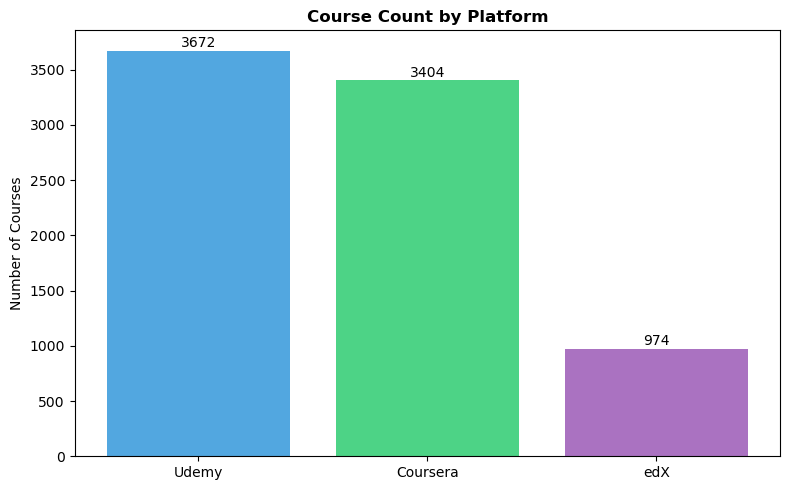


Total courses in catalogue : 8,050
Platforms covered          : 3


In [12]:
# ── Platform coverage statistics (Course Count Only) ──────────────────────────
fig, ax = plt.subplots(figsize=(8, 5))

# Course count by platform
platform_counts = courses['platform'].value_counts()

# Predefined colors (blue, green, purple)
colors = ['#3498db', '#2ecc71', '#9b59b6'][:len(platform_counts)]

bars = ax.bar(platform_counts.index, platform_counts.values,
              color=colors, alpha=0.85)

# Formatting
ax.set_title('Course Count by Platform', fontweight='bold')
ax.set_ylabel('Number of Courses')

# Add labels above bars
for i, v in enumerate(platform_counts.values):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'course_catalogue_stats.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary stats
print(f'\nTotal courses in catalogue : {len(courses):,}')
print(f'Platforms covered          : {courses["platform"].nunique()}')

## 10.0 — Save Course Recommender Artifacts

In [13]:
# ── Serialise course recommender components ───────────────────────────────────
course_recommender = {
    'tfidf_vectorizer'     : COURSE_TFIDF,
    'course_matrix'        : COURSE_MATRIX,
    'courses_df'           : courses,
    'education_level_map'  : EDUCATION_COURSE_LEVELS,
    'level_map'            : LEVEL_MAP,
}

joblib.dump(course_recommender, MODEL_DIR / 'course_recommender_v2.pkl')
print(f'Course recommender saved: {MODEL_DIR}/course_recommender_v2.pkl')

# Save education level mapping as JSON
with open(ARTIFACTS_DIR / 'education_course_levels.json', 'w') as f:
    json.dump(EDUCATION_COURSE_LEVELS, f, indent=2)

# Summary
summary = {
    'notebook'            : '06 — Course Recommender & Learning Path Generator',
    'courses_indexed'     : len(courses),
    'platforms'           : courses['platform'].unique().tolist(),
    'tfidf_vocab_size'    : len(COURSE_TFIDF.vocabulary_),
    'ngram_range'         : '(1, 3)',
    'learning_path_stages': ['Foundation', 'Intermediate', 'Advanced'],
    'user_types_supported': list(EDUCATION_COURSE_LEVELS.keys()),
    'gap_integration'     : 'Direct — courses matched per skill gap from Notebook 04',
    'figures_generated'   : [str(p) for p in FIGURES_DIR.glob('*.png')],
}

with open(ARTIFACTS_DIR / '06_course_recommender_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print()

print(f'  Courses indexed            : {len(courses):,}')
print(f'  Platforms                  : {courses["platform"].nunique()}')
print(f'  Learning path stages       : Foundation → Intermediate → Advanced')
print(f'  User types supported       : {list(EDUCATION_COURSE_LEVELS.keys())}')


Course recommender saved: models/course_recommender_v2.pkl

  Courses indexed            : 8,050
  Platforms                  : 3
  Learning path stages       : Foundation → Intermediate → Advanced
  User types supported       : ['cbc', '8-4-4', 'diploma', 'graduate', 'postgraduate', 'professional']
